In [1]:
# libraries needed
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import geocoder

# pandas options
pd.set_option('display.max_rows',250) # max rows to display
pd.set_option('max_colwidth', 100) # max column width to display
pd.options.display.float_format = '{:.3f}'.format # float format to display

In [2]:
df2 = pd.read_excel(r'.\Data\Input\Indicator data 1.2.xlsx',sheet_name = 'Table 1',skiprows = 14) # open excel file
col_names = list(df2.columns) # get column names in a list
col_names = [x.replace(' ','_') for x in col_names] # replace spaces with underscore for easier selection using mouse clicking
df2.columns = col_names # apply new column names

display(
    df2.shape # show the shape of the dataframe
    ,df2.head() # and the top 5 rows
)

(1266, 12)

,Reporting_period,Period_of_coverage,Breakdown,ONS_code,Level,Level_description,Gender,Indicator_value,CI_lower,CI_upper,Denominator,Numerator
0,2014-2016,01/01/2014 to 31/12/2016,National,E92000001,National,All registered patients in England,Female,34.200,33.800,34.600,85904493,28602
1,2013-2015,01/01/2013 to 31/12/2015,National,E92000001,National,All registered patients in England,Female,34.300,33.900,34.700,85144932,28532
2,2012-2014,01/01/2012 to 31/12/2014,National,E92000001,National,All registered patients in England,Female,34.600,34.200,35.000,84473478,28634
3,2011-2013,01/01/2011 to 31/12/2013,National,E92000001,National,All registered patients in England,Female,34.700,34.300,35.100,84091606,28742
4,2010-2012,01/01/2010 to 31/12/2012,National,E92000001,National,All registered patients in England,Female,34.600,34.200,35.000,83874567,28672


## Variable engineering

In [3]:
# get start and end year from Reporting_period and store them in new variables
df2['Start_year'] = df2['Reporting_period'].copy().replace(r'\-\d+','', regex = True) # get start year from Reporting_period and store in a new variable
df2['End_year'] = df2['Reporting_period'].copy().replace(r'\d+\-','', regex = True) # dp the same as above for end year
df2['Start_year'] = pd.to_numeric(df2['Start_year']) # turn the data type numeric for both of these variables
df2['End_year'] = pd.to_numeric(df2['End_year']) # same as above

# get start and end dates from Period_of_coverage and store them in new variables
df2['Start_coverage'] = df2['Period_of_coverage'].copy().replace(r'\s+to\s+.*','', regex = True)
df2['End_coverage'] = df2['Period_of_coverage'].copy().replace(r'.*\s+to\s+','', regex = True)
df2['Start_coverage'] = pd.to_datetime(df2['Start_coverage'], infer_datetime_format = True)
df2['End_coverage'] = pd.to_datetime(df2['End_coverage'], infer_datetime_format = True)

df2.drop(columns = ['Reporting_period','Period_of_coverage'], inplace = True) # drop the variables we've just extracted data from

df2.describe(include = 'all') # descriptive statistics for all kinds of variables

,Breakdown,ONS_code,Level,Level_description,Gender,Indicator_value,CI_lower,CI_upper,Denominator,Numerator,Start_year,End_year,Start_coverage,End_coverage
count,1266,1266,1266,1266,1266,1266.000,1266.000,1266.000,1266.000,1266.000,1266.000,1266.000,1266,1266
unique,2,220,214,218,1,nan,nan,nan,nan,nan,nan,nan,6,6
top,CCG,E38000033,01H,NHS Barking and Dagenham CCG,Female,nan,nan,nan,nan,nan,nan,nan,2012-01-01 00:00:00,2011-12-31 00:00:00
freq,1260,6,6,6,1266,nan,nan,nan,nan,nan,nan,nan,212,212
first,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,2009-01-01 00:00:00,2011-12-31 00:00:00
last,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,2014-01-01 00:00:00,2016-12-31 00:00:00
mean,NaN,NaN,NaN,NaN,NaN,34.507,28.425,41.573,801522.343,271.329,2011.490,2013.490,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.993,3.942,4.725,5786366.043,1959.065,1.706,1.706,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,21.700,11.300,29.200,104769.000,14.000,2009.000,2011.000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,32.000,26.100,38.300,259306.750,86.000,2010.000,2012.000,NaN,NaN


In [4]:
# Curiocity purposes. Does all of Level_description contain "NHS" in it?
non_nhs_keyw_ind = df2['Level_description'][~(df2['Level_description'].str.contains('NHS', case = False))].index # collect indices of rows that don't contain the keyword 'NHS' (case insensitive)
print("There rows don't contain the keyword 'NHS':")
display(df2.loc[non_nhs_keyw_ind]) # displays the data

There rows don't contain the keyword 'NHS':


,Breakdown,ONS_code,Level,Level_description,Gender,Indicator_value,CI_lower,CI_upper,Denominator,Numerator,Start_year,End_year,Start_coverage,End_coverage
0,National,E92000001,National,All registered patients in England,Female,34.200,33.800,34.600,85904493,28602,2014,2016,2014-01-01,2016-12-31
1,National,E92000001,National,All registered patients in England,Female,34.300,33.900,34.700,85144932,28532,2013,2015,2013-01-01,2015-12-31
2,National,E92000001,National,All registered patients in England,Female,34.600,34.200,35.000,84473478,28634,2012,2014,2012-01-01,2014-12-31
3,National,E92000001,National,All registered patients in England,Female,34.700,34.300,35.100,84091606,28742,2011,2013,2011-01-01,2013-12-31
4,National,E92000001,National,All registered patients in England,Female,34.600,34.200,35.000,83874567,28672,2010,2012,2010-01-01,2012-12-31
5,National,E92000001,National,All registered patients in England,Female,34.300,33.900,34.700,83874567,28569,2009,2011,2009-01-01,2011-12-31


# Variable cleaning

In [5]:
df2['Location'] = df2['Level_description'][df2['Level_description'].str.contains('NHS')].replace( # use regex to:
    [
        r'(?i)\s+ccg' # 1) find abbreviation containing one or more spaces followed by "ccg" case insensitive by using "(?i)" in the beginning and replace it with (a) below
        ,r'$' # 2) find the end of each sentence and replace it with (b) below
        ,r'\s{2,}' # 3) find 2 white spaces or above and replace them with (c) below
        ,r'^\s+|\s+$' # 4) find white spaces in beginning and end and replace them with (d) below
    ]
    
    ,[
        ' Clinical Commissioning Group' # a) replace abbreviations with full text
        ,', UK' # b) add UK at the end of each location to make it easier to identify a location on maps
        ,' ' # c) with a single space
        ,''# d) "" indicates empty string
    ]
    ,regex=True) # using regular expressions, practice here https://regex101.com/

# Let's fix some locations with more detailed addresses using a temporary variable for visual inspection before pushing the changes to the working column ("Location")
temp_col = df2['Location'].dropna() # copy the column without the NaN values in a new variable
temp_col.loc[temp_col[temp_col.str.contains(r'NHS\sHardwick', case = False)].index] = 'NHS Hardwick Clinical Commission Group, Chesterfield, S41 7PF, UK' # this find all values containing "NHS Hardwich" and asigns it the value after the equals sign
temp_col.loc[temp_col[temp_col.str.contains(r'NHS\sMorecambe|NHS\s+Lancashire\s+North', case = False)].index] = 'NHS Morecambe Bay Clinical Commission Group, Preston, PR26 6TR, UK'
temp_col.loc[temp_col[temp_col.str.contains(r'NHS\sNorth\s+Cumbria', case = False)].index] = 'NHS North Cumbria Clinical Commission Group, Penrith, CA1 2SE, UK'
temp_col.loc[temp_col[temp_col.str.contains(r'NHS\sKingston', case = False)].index] = 'NHS Kingston Clinical Commissioning Group, Teddington, TW11 8HU, UK'
temp_col.loc[temp_col[temp_col.str.contains(r'NHS\sOldham', case = False)].index] = 'NHS Oldham Clinical Commissioning Group, Oldham, OL9 6EE, UK'
temp_col.loc[temp_col[temp_col.str.contains(r'NHS\sSlough', case = False)].index] = 'NHS Slough Clinical Commissioning Group, Windsor, SL4 3DP, UK'
# temp_col.value_counts() # visual check of the values
df2['Location'].update(temp_col) # this overwrites the updated values from temp_col to "Location"

nhs_locations = df2['Location'].dropna().unique().tolist() # making a list of the locaitons
len(nhs_locations) # how many unique ones are there?

216

# Resolve named locations to location data
The ipython magic %%time tells how long a cell takes to execute

In [6]:
%%time
google_results = [] # start with an empty list to append each result to
for x in nhs_locations: # for each location
    google_results.append(geocoder.google(x, method = 'geocode', key = os.environ["googlemaps_api_key"] # geocode it using a freely available google maps api key
                                        ,components = 'country:GB')) # and look for this location in Great Britain

Wall time: 1min 53s


In [7]:
print(google_results[0].json) # let's see what the output is

{'accuracy': 'GEOMETRIC_CENTER', 'address': 'Steeton, West Yorkshire, Steeton, Keighley BD20 6RB, UK', 'bbox': {'northeast': [53.9011651802915, -1.948652519708498], 'southwest': [53.8984672197085, -1.951350480291502]}, 'city': 'West Yorkshire', 'confidence': 9, 'country': 'GB', 'county': 'West Yorkshire', 'lat': 53.8998162, 'lng': -1.9500015, 'ok': True, 'place': 'ChIJVzx7O9nxe0gRV1IUFq_Mzfk', 'postal': 'BD20 6RB', 'postal_town': 'Keighley', 'quality': 'establishment', 'raw': {'address_components': [{'long_name': 'Steeton', 'short_name': 'Steeton', 'types': ['route']}, {'long_name': 'West Yorkshire', 'short_name': 'West Yorkshire', 'types': ['locality', 'political']}, {'long_name': 'Keighley', 'short_name': 'Keighley', 'types': ['postal_town']}, {'long_name': 'West Yorkshire', 'short_name': 'West Yorkshire', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'England', 'short_name': 'England', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'Uni

## Collecting location data

In [8]:
elements_of_interest = ['postal_town','city','county','country','lat','lng','confidence'] # location elements we are interested to know
coord_list = [] # empty list to store results - meant to be used as a list of lists

for i in range(len(google_results)): # for each google geocode result
    temp_list = [np.nan] * len(elements_of_interest) # start with nan values
    for j, element in enumerate(elements_of_interest): # and for each element of interest
        try: temp_list[j] = google_results[i][0].json[element] # add to temporary list
        except: pass # if it can, otherwise skip it
    coord_list.append(temp_list) # and append the populated elements in a master list (list of lists)
            
location_df = pd.DataFrame(coord_list, columns = elements_of_interest) # convert the results to a dataframe
location_df.insert(0, 'Location', nhs_locations) # and insert a column with the original locations

print("Location dataframe descriptive statistics:")
display(location_df.describe(include = 'all')) # describe the dataframe, for numericals this gives basic descriptive statistics and for objects it gives value count, unique value counts, top value and its frequency

Location dataframe descriptive statistics:


,Location,postal_town,city,county,country,lat,lng,confidence
count,216,204,216,141,216,216.000,216.000,216.000
unique,216,149,164,53,1,nan,nan,nan
top,NHS Barking and Dagenham CCG,London,London,Greater London,GB,nan,nan,nan
freq,1,18,18,26,216,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,52.494,-1.130,8.963
std,NaN,NaN,NaN,NaN,NaN,1.167,1.156,0.396
min,NaN,NaN,NaN,NaN,NaN,50.340,-4.795,4.000
25%,NaN,NaN,NaN,NaN,NaN,51.473,-2.074,9.000
50%,NaN,NaN,NaN,NaN,NaN,52.473,-1.196,9.000
75%,NaN,NaN,NaN,NaN,NaN,53.448,-0.206,9.000


In [9]:
print("Showing the top and bottom snippet of the dataframe respectively:")
display(
    location_df.head() # this shows the top of the dataframe
    ,location_df.tail() # and this shows the bottom of the dataframe
)

Showing the top and bottom snippet of the dataframe respectively:


,Location,postal_town,city,county,country,lat,lng,confidence
0,"NHS Airedale, Wharfedale and Craven CCG",Keighley,West Yorkshire,West Yorkshire,GB,53.900,-1.950,9
1,NHS Ashford CCG,NaN,Canterbury,NaN,GB,51.284,1.092,9
2,NHS Aylesbury Vale CCG,Aylesbury,Aylesbury,NaN,GB,51.822,-0.826,9
3,NHS Barking and Dagenham CCG,Barking,Barking,Greater London,GB,51.538,0.079,9
4,NHS Barnet CCG,London,London,Greater London,GB,51.625,-0.152,9


,Location,postal_town,city,county,country,lat,lng,confidence
211,NHS Coastal West Sussex,Worthing,Worthing,NaN,GB,50.818,-0.411,9
212,NHS Gateshead,Gateshead,Gateshead,Tyne and Wear,GB,54.945,-1.616,9
213,NHS Guildford and Waverley,Guildford,Guildford,NaN,GB,51.238,-0.576,9
214,NHS Newcastle North and East,Newcastle upon Tyne,Newcastle upon Tyne,NaN,GB,54.970,-1.713,9
215,NHS Newcastle West,Newcastle upon Tyne,High Heaton,Tyne and Wear,GB,55.003,-1.593,9


## Saving location df

In [10]:
location_df.to_csv(r'.\Data\Output\NHS locations.csv', index = False)
# location_df = pd.read_csv(r'.\Data\Output\NHS locations.csv')

In [11]:
loc_names = ['postal_town', 'city','county'] # columns names to select for merging onto the main dataframe
locations = location_df[['Location'] + loc_names] # making a slice of the dataframe instead of copying the data to keep RAM use down

In [12]:
# Before actual merging, columns in loc_names are dropped (ignoring errors) to prevent duplication. drop_duplicates() protects from increasing the dataframe length unecessarily
# how = "left" use only keys from left frame, similar to a SQL left outer join; preserving key order (from: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)
# on = "Location" means the key column to merge is "Location" and needs to be present in both dataframes
df2 = df2.drop(columns = loc_names, errors = 'ignore').merge(locations.drop_duplicates(), how = 'left', on = 'Location')

# Choropleth of breast cancer mortality rates

In [13]:
choropleth_data = df2.drop(columns = ['Start_year','End_year'], errors = 'ignore').groupby(loc_names, as_index = False,sort = True).median() # groups data by columns in loc_names and calculates the median of values from each group
choropleth_data.head()

,postal_town,city,county,Indicator_value,CI_lower,CI_upper,Denominator,Numerator
0,Aldershot,Aldershot,Hampshire,33.000,26.950,40.000,330031.500,104.000
1,Barking,Barking,Greater London,35.350,27.450,44.750,306025.500,71.500
2,Barnet,Barnet,Greater London,32.850,27.400,39.150,479531.000,127.500
3,Barnsley,Barnsley,South Yorkshire,32.850,27.300,39.150,376853.500,124.500
4,Basildon,Basildon,Essex,37.750,32.100,44.150,404544.500,157.500


## Loading UK shapefile

In [14]:
# set the filepath and load in a shapefile containing map data
fp = './Data/Great_Britain_shapefile/infuse_dist_lyr_2011.shp'
map_df = gpd.read_file(fp)

In [15]:
map_df.head() # and this is how the shapefile looks like

,geo_code,geo_label,geo_labelw,label,name,geometry
0,W06000016,Rhondda Cynon Taf,Rhondda Cynon Taf,W92000004W06000016,Rhondda Cynon Taf,"POLYGON ((291902.5 196289.607, 291899.094 196291.407, 291883.772 196308.588, 291801.704 196400.6..."
1,S12000013,Eilean Siar,None,S92000003S12000013,Eilean Siar,"(POLYGON ((138021.5 955416.1999999993, 138026.2000000002 955416, 138027 955417.5, 138023.5 95542..."
2,W06000013,Bridgend,Pen-y-bont ar Ogwr,W92000004W06000013,Bridgend,"POLYGON ((280647.356 182792.75, 280647.402 182792.743, 280656.334 182791.46, 280661.594 182790.7..."
3,E07000138,Lincoln,None,E92000001E07000138,Lincoln,"POLYGON ((495362.339 373435.025, 495367.034 373436.048, 495381.594 373439.219, 495393.238 373442..."
4,E07000166,Richmondshire,None,E92000001E07000166,Richmondshire,"POLYGON ((392540.053 507436.934, 392689 507651.5, 392917.406 507664.75, 393003.839 507666.532, 3..."


In [16]:
vars_to_merge = ['Indicator_value' ,'CI_lower' ,'CI_upper'] # variables to merge from choropleth data on map dataframe

def merge_loc_df(merge_var, map_df = map_df, choropleth_data = choropleth_data, loc_names = loc_names):
    map_df_loc = map_df[merge_var].to_frame() # convert map df to a dataframe
    
    map_df1 = map_df_loc.merge(choropleth_data[[loc_names[0]] + vars_to_merge].rename(columns = {loc_names[0]: merge_var}), on = merge_var, how = 'left') # merge on postal_town
    map_df2 = map_df_loc.merge(choropleth_data[[loc_names[1]] + vars_to_merge].rename(columns = {loc_names[1]: merge_var}), on = merge_var, how = 'left') # merge on city
    map_df3 = map_df_loc.merge(choropleth_data[[loc_names[2]] + vars_to_merge].rename(columns = {loc_names[2]: merge_var}), on = merge_var, how = 'left') # merge on county

    map_dfs = [map_df1, map_df2, map_df3] # collection of map dataframes

    map_dfs_len = [] # empty list to store map dataframe lengths
    
    for map_mdf in map_dfs:
        map_dfs_len.append(len(map_mdf)) # add each map dataframe length in the list
    map_dfs_len = pd.Series(map_dfs_len).sort_values(ascending = False) # and sort by length values to start with the smallest - doing this to avoid duplicated indices

    map_df_loc = map_dfs[map_dfs_len.index[0]].fillna(map_dfs[map_dfs_len.index[1]]) # fill in missing values from the second longest map dataframe
    try: # and try to do the same with the remaining map dataframes
        for i in (map_dfs_len[2:].index):
            map_df_loc = map_df_loc.fillna(map_dfs[map_dfs_len.index[i]])
    except:
        pass

    print(
        '\nNumber of location names from given map data:', len(map_df_loc)
        ,'\nMap df shape before merging:', map_df.shape
         )
    map_df = map_df.merge(map_df_loc, how = 'left', on = merge_var, copy = False, sort = False)
    print('Map df shape after merging:', map_df.shape)
    return map_df

In [17]:
merge_vname = 'geo_label' # existing variable in map df to use for merging data from choropleth dataframe
map_df = merge_loc_df(merge_vname)


Number of location names from given map data: 407 
Map df shape before merging: (404, 6)
Map df shape after merging: (407, 9)


In [18]:
print(
    "Cities/towns to expect colour fill where the intensity depends on breast cancer mortality rate:\n"
    ,map_df[map_df['Indicator_value'].notna()]['name'].unique()
    ,"\n\nDataframe type:",type(map_df) # needs to be GeoDataFrame
)

Cities/towns to expect colour fill where the intensity depends on breast cancer mortality rate:
 ['Lincoln' 'Nottingham' 'Tamworth' 'Blaenau Gwent' 'Sutton' 'Norwich'
 'Gloucester' 'Crawley' 'Dover' 'York' 'Leicester' 'Gateshead'
 'Bromsgrove' 'Midlothian' 'Swindon' 'Rotherham' 'Warwick' 'Inverclyde'
 'Walsall' 'Strabane' 'Flintshire' 'Chelmsford' 'Swansea' 'Reading'
 'Basildon' 'Lewes' 'Wolverhampton' 'Stockport' 'Mid Devon'
 'Southend-on-Sea' 'Rochdale' 'Wigan' 'Coventry' 'Fareham' 'Lisburn'
 'Newcastle upon Tyne' 'Worcester' 'West Lancashire' 'Darlington'
 'Cambridge' 'Teignbridge' 'Manchester' 'Barnet' 'Corby' 'Redbridge'
 'Derby' 'Amber Valley' 'Warrington' 'Harlow' 'Bradford' 'Hounslow'
 'Salford' 'Oldham' 'Wakefield' 'Sefton' 'Leeds' 'Milton Keynes'
 'Middlesbrough' 'Barnsley' 'Oxford' 'Liverpool' 'Sheffield' 'Preston'
 'Ryedale' 'Ipswich' 'Northampton' 'Eastleigh' 'Stockton-on-Tees'] 

Dataframe type: <class 'geopandas.geodataframe.GeoDataFrame'>


In [19]:
map_df.loc[:, vars_to_merge] = map_df.loc[:, vars_to_merge].fillna(0) # filling in zeroes for breast cancer mortality rate (Indicator_value) and confidence intervals
map_df.head()

,geo_code,geo_label,geo_labelw,label,name,geometry,Indicator_value,CI_lower,CI_upper
0,W06000016,Rhondda Cynon Taf,Rhondda Cynon Taf,W92000004W06000016,Rhondda Cynon Taf,"POLYGON ((291902.5 196289.607, 291899.094 196291.407, 291883.772 196308.588, 291801.704 196400.6...",0.000,0.000,0.000
1,S12000013,Eilean Siar,None,S92000003S12000013,Eilean Siar,"(POLYGON ((138021.5 955416.1999999993, 138026.2000000002 955416, 138027 955417.5, 138023.5 95542...",0.000,0.000,0.000
2,W06000013,Bridgend,Pen-y-bont ar Ogwr,W92000004W06000013,Bridgend,"POLYGON ((280647.356 182792.75, 280647.402 182792.743, 280656.334 182791.46, 280661.594 182790.7...",0.000,0.000,0.000
3,E07000138,Lincoln,None,E92000001E07000138,Lincoln,"POLYGON ((495362.339 373435.025, 495367.034 373436.048, 495381.594 373439.219, 495393.238 373442...",34.600,29.050,40.850
4,E07000166,Richmondshire,None,E92000001E07000166,Richmondshire,"POLYGON ((392540.053 507436.934, 392689 507651.5, 392917.406 507664.75, 393003.839 507666.532, 3...",0.000,0.000,0.000


# Plotting map

C:\Users\georgejoseph\anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


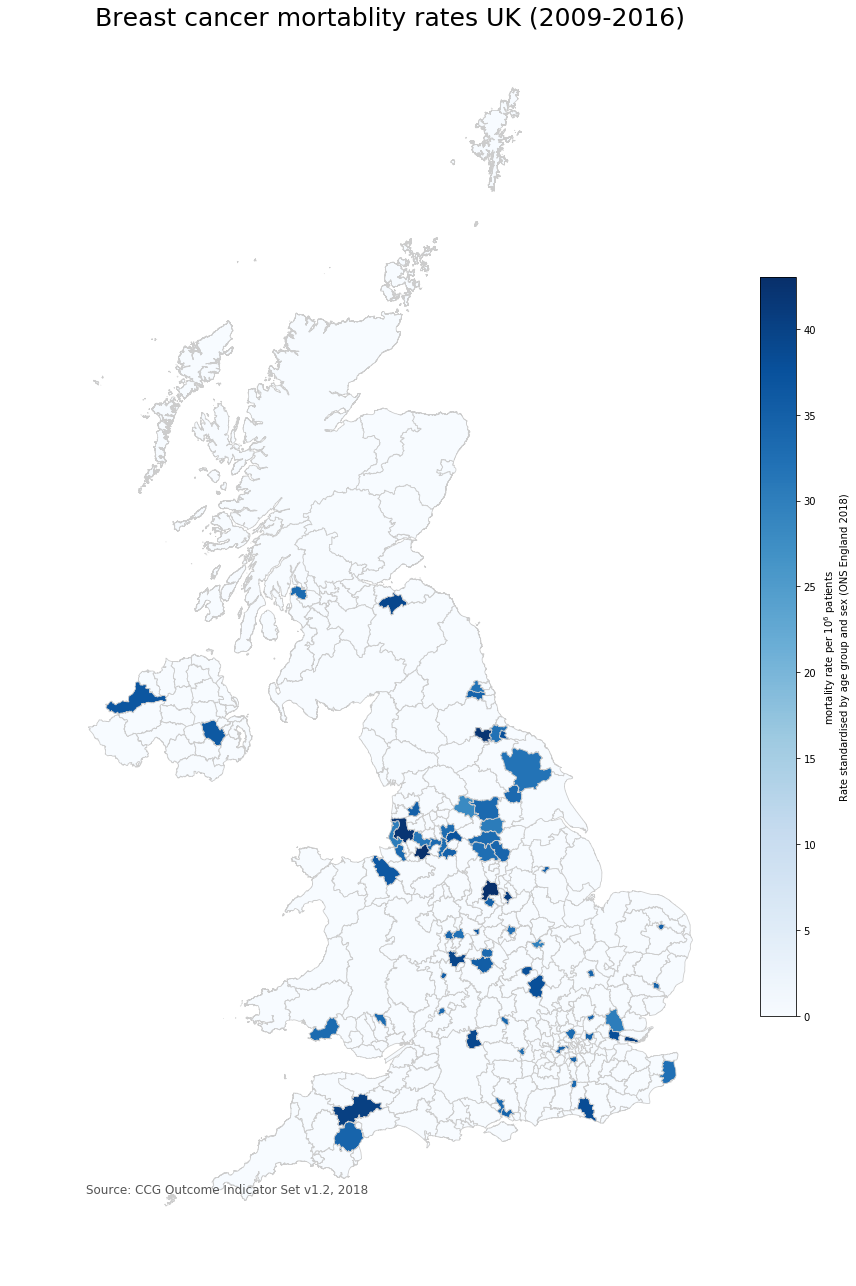

In [20]:
val_vname = 'Indicator_value' # set a variable that will call whatever column we want to visualise on the map

vmin, vmax = int(np.floor(map_df[val_vname].min())), int(np.ceil(map_df[val_vname].max())) # set the range for the choropleth

fig, ax = plt.subplots(1, figsize = (12, 20), tight_layout = True) # create figure and axes for Matplotlib

map_df.fillna(0).plot(column = val_vname, cmap = 'Blues', linewidth = 0.8, ax = ax, edgecolor = '0.8') # create map

ax.axis('off') # remove the axis

ax.set_title('Breast cancer mortablity rates UK (2009-2016)', fontdict = {'fontsize': '25', 'fontweight' : '3'}) # add a title

ax.annotate('Source: CCG Outcome Indicator Set v1.2, 2018',xy = (0.1, .08),  xycoords = 'figure fraction', horizontalalignment = 'left'
            ,verticalalignment = 'top', fontsize = 12, color = '#555555') # create an annotation for the data source

sm = plt.cm.ScalarMappable(cmap = 'Blues', norm = plt.Normalize(vmin = vmin, vmax = vmax)) # Create colorbar as a legend

sm._A = [] # empty array for the data range

cbar = fig.colorbar(sm, fraction = 0.05, pad = 0.05, label = 'mortality rate per 10$^{6}$ patients\nRate standardised by age group and sex (ONS England 2018)') # add the colorbar to the figure

plt.show() # show plot
fig.savefig("map_export.png", dpi = 300) # export plot as a .png file

Environmental and lifestyle factors to investigate (only cover 30-40% of cases) <sub>from [here](https://www.nationalbreastcancer.org/breast-cancer-risk-factors)</sub>:
* smoking
* air polution
* Lack of Physical Activity:  A sedentary lifestyle with little physical activity can increase your risk for breast cancer.
* Poor Diet:  A diet high in saturated fat and lacking fruits and vegetables can increase your risk for breast cancer.  
* Being Overweight or Obese:  Being overweight or obese can increase your risk for breast cancer. Your risk is increased if you have already gone through menopause.  
* Drinking Alcohol:  Frequent consumption of alcohol can increase your risk for breast cancer. The more alcohol you consume, the greater the risk.
* Radiation to the Chest:  Having radiation therapy to the chest before the age of 30 can increase your risk for breast cancer.  
* Combined Hormone Replacement Therapy (HRT):  Taking combined hormone replacement therapy, as prescribed for menopause, can increase your risk for breast cancer and increases the risk that the cancer will be detected at a more advanced stage.